<img src="PEST++V3_cover.jpeg" style="float: left">

<img src="flopylogo.png" style="float: right">

<img src="AW&H2015.png" style="float: center">

# History match the Freyberg model using a two parameters ``K`` and ``R`` using head and flux observations

#### Where are we on the Goldilocks complexity curve? 

<img src="Hunt1998_sweetspot.png" style="float: center">



The runs so far were intended to be greatly oversimplified so as to be a starting point for adding complexity. However, when we added just __*one more parameter*__ for a total of 2 parameters uncerainty for some forecasts got appreciably __worse__.  And these parameters cover the entire model domain, which is unrealistic for the natural world!  Are we past the "sweetspot" and should avoid any additional complexity even if our model looks nothing like reality?  

Adding parameters in and of itself is not the real problem.  Rather, it is adding parameters that influence forecasts but are unconstrained by observations so that they are free to wiggle and ripple uncertainty to our forcasts.  If observations are added that help constrain the parameters, the forecast observation will be more certain. That is, the natural flip side of adding parameters is constraining them, with data (first line of defense) or soft-knowledge and problem dimension reduciton (SVD).  

Anderson et al. (2015) suggest that at a minimum groundwater models be history matched to heads and fluxes.  There is a flux observation in our PEST control file, but it was given zero weight.  Let's see what happens if we move our model to the minimum calibration of Anderson et al.

#### Objectives for this notebook are to:

1) Add a flux observation to the measurement objective function of our Freyberg model

2) Explore the effect of adding the observation to history matching, parameter uncertainty, and forecast uncertainty

In [1]:
%matplotlib inline
import os
import sys
sys.path.append("..")
import shutil
import pandas as pd
import matplotlib.pyplot as plt
import pyemu

In [2]:
import freyberg_setup as fs
pst_name = fs.PST_NAME_KR
working_dir = fs.WORKING_DIR_KR
fs.setup_pest_kr()
pst = pyemu.Pst(os.path.join(working_dir,pst_name))
pst.control_data.noptmax = 0
pst.write(os.path.join(working_dir,pst_name))

['botm.ref', 'extract_zone_array.py', 'forecasts_true.csv', 'freyberg.bas', 'freyberg.dbf', 'freyberg.dis', 'freyberg.hds', 'freyberg.heads', 'freyberg.heads_potobs.ins', 'freyberg.hyd', 'freyberg.list', 'freyberg.locations', 'freyberg.mpbas', 'freyberg.mpenpt', 'freyberg.mplist', 'freyberg.mpnam', 'freyberg.mppthln', 'freyberg.mpsim', 'freyberg.oc', 'freyberg.pcg', 'freyberg.rivflux', 'freyberg.shp', 'freyberg.shx', 'freyberg.travel', 'freyberg.truth.lpf', 'freyberg.truth.nam', 'freyberg.truth.rch', 'freyberg.truth.riv', 'freyberg.truth.wel', 'hk.truth.ref', 'hk.zones', 'ibound.ref', 'kzone.ref', 'mpath.in', 'obs_loc.csv', 'potobs_group.csv', 'Process_output.py', 'run_true_model.py', 'strt.ref', 'Weights_and_best_PHI.xlsx']

changing model workspace...
   freyberg_kr
FloPy is using the following executable to run the model: /Users/rjhunt1/GW1876-2/activities/freyberg_k_and_r_fluxobs/freyberg_kr/mfnwt

                                  MODFLOW-NWT-SWR1 
    U.S. GEOLOGICAL SURVEY MODUL

In [3]:
pyemu.helpers.run("pestpp {0}".format(pst_name),cwd=working_dir)

run():./pestpp freyberg_kr.pst


``PEST++`` only ran the model one time - because NOPTMAX=0, but that is what we want at this point to interrogate the model at initial values.  

### Let's look at all observations in the PEST run

In [4]:
pst = pyemu.Pst(os.path.join(working_dir,pst_name))
pst.observation_data

,obsnme,obsval,weight,obgnme
obsnme,,,,
flx_constan_19700102,flx_constan_19700102,-4.073839e+02,0.0,flx_constan
flx_in-out_19700102,flx_in-out_19700102,-1.373190e+01,0.0,flx_in-out
flx_percent_19700102,flx_percent_19700102,-2.200000e-01,0.0,flx_percent
flx_recharg_19700102,flx_recharg_19700102,6.004800e+03,0.0,flx_recharg
flx_river_l_19700102,flx_river_l_19700102,-3.706027e+03,0.0,calflux
flx_storage_19700102,flx_storage_19700102,0.000000e+00,0.0,flx_storage
flx_total_19700102,flx_total_19700102,-1.373193e+01,0.0,flx_total
flx_wells_19700102,flx_wells_19700102,-1.905120e+03,0.0,flx_wells
flx_constan_19750101,flx_constan_19750101,-1.796678e+02,0.0,flx_constan


Wow!  that's a lot of observations.  Why so many?  Answer:  we are "carrying" lots of model outputs that may be of interest to us later __(not just places and times where we have actual measurements)__.  These outputs include forecasts as well as *"potential" observation* locations we will use in dataworth analysis (more on that later)

But, the calibration only uses observations where you assign weights.  Let's get a listing of just those.

In [5]:
pst.observation_data.loc[pst.nnz_obs_names,:]

,obsnme,obsval,weight,obgnme
obsnme,,,,
cr03c10_19700102,cr03c10_19700102,22.331451,5.0,calhead
cr03c16_19700102,cr03c16_19700102,18.526869,5.0,calhead
cr04c09_19700102,cr04c09_19700102,24.412637,5.0,calhead
cr10c02_19700102,cr10c02_19700102,27.985834,5.0,calhead
cr14c11_19700102,cr14c11_19700102,21.070509,5.0,calhead
cr16c17_19700102,cr16c17_19700102,15.468176,5.0,calhead
cr22c11_19700102,cr22c11_19700102,20.485881,5.0,calhead
cr23c16_19700102,cr23c16_19700102,15.308345,5.0,calhead
cr25c05_19700102,cr25c05_19700102,22.408501,5.0,calhead


Let's give the observation ``rivflux_cal`` a non-zero weight.  You can do this in a text editor but we'll do it in the next block and see the report out for convenience. We chose a new weight of 0.05 for this problem, but we'll spend more time on the concepts involved with observation weighting in a later notebook.

In [6]:
obs = pst.observation_data
obs.loc[obs.obgnme=="calflux","weight"] = 0.05 #super subjective
pst.observation_data.loc[pst.nnz_obs_names,:]

,obsnme,obsval,weight,obgnme
obsnme,,,,
flx_river_l_19700102,flx_river_l_19700102,-3706.027000,0.05,calflux
cr03c10_19700102,cr03c10_19700102,22.331451,5.00,calhead
cr03c16_19700102,cr03c16_19700102,18.526869,5.00,calhead
cr04c09_19700102,cr04c09_19700102,24.412637,5.00,calhead
cr10c02_19700102,cr10c02_19700102,27.985834,5.00,calhead
cr14c11_19700102,cr14c11_19700102,21.070509,5.00,calhead
cr16c17_19700102,cr16c17_19700102,15.468176,5.00,calhead
cr22c11_19700102,cr22c11_19700102,20.485881,5.00,calhead
cr23c16_19700102,cr23c16_19700102,15.308345,5.00,calhead


### Now let's change NOPTMAX from 0 to 20 so we can see what the effect of weighting the flux target is

In [7]:
pst.control_data.noptmax = 20
pst.write(os.path.join(working_dir,pst_name))

### And we'll run the model - look at the terminal window where you launched this notebook to see the progress of PEST++.  Advance through the code blocks when you see a 0 returned.

In [8]:
pyemu.helpers.run("pestpp {0}".format(pst_name),cwd=working_dir)

run():./pestpp freyberg_kr.pst


Let's explore the results, how did we do with fit (lowering PHI)?

In [9]:
df_obj = pd.read_csv(os.path.join(working_dir,pst_name.replace(".pst",".iobj")),index_col=0)
df_obj

,model_runs_completed,total_phi,measurement_phi,regularization_phi,flx_river_l,forehead,vol_total,flx_recharg,vol_storage,vol_percent,...,vol_recharg,flx_storage,head,flx_in-out,vol_river_l,vol_constan,flx_total,flx_percent,pothead,foreflux
iteration,,,,,,,,,,,,,,,,,,,,,
0,0,1336.490,1336.490,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,8,860.627,860.627,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,15,857.172,857.172,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,23,857.191,857.191,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## Egads!  Our Phi is a bit larger!  Are we moving backwards? Oh wait, we added a new weighted observation, so we can't compare it directly to what we had with only head observations.


#### Okay, what did it do to our parameter uncertainty?

In [10]:
df_paru = pd.read_csv(os.path.join(working_dir,pst_name.replace(".pst",".par.usum.csv")),index_col=0)
df_paru

,prior_mean,prior_stdev,prior_lower_bound,prior_upper_bound,post_mean,post_stdev,post_lower_bound,post_upper_bound
name,,,,,,,,
HK,0.69897,0.5,-0.30103,1.69897,0.829725,0.051335,0.727056,0.932395


# Hold the phone - only K is showing here.  Did we run PESTCHEK before burning the silicon? 

 (Remember last notebook where we said:  "Let's run PESTCHEK and see what it says about our freyberg.pst file"?)

In [11]:
pyemu.helpers.run("pestchek {0}".format(pst_name),cwd=working_dir)

run():./pestchek freyberg_kr.pst


#### Well the instructors gave you the same PEST control file as last exerisce!  Some one should tell them that it was "curious" in the last notebook but vexxing now, because we again see that in the PESTCHEK warning section it says "All parameters belonging to the parameter group "rch" are either fixed or tied". That is flagged as a warning because PESTCHEK is wondering (with good reason in this case) why would it not be adjustable after you went to all the trouble to define it as a parameter.  But, there  are times you may want to do this, so it is classified as a warning and isn't going to stop you.

#### But that is not what we want, we want to make recharge a parameter in this activity and redo our work (did we remember to mention the importance of running PESTCHEK?)

### Open the PEST control file freyberg.pst in your text editor.  

1) Look in the parameter data section

2) Find the parameter __rch_0__ (the recharge for the calibration period) and make it adjustable (hint:  look at the other parameters) 

3) Save the file

4) Run PESTCHEK on the PEST control file in a seperate terminal window or by executing the next code block and looking at the terminal window where you launched this notebook

## Or run this next pyemu block

In [12]:
pst.parameter_data.loc["rch_0",'partrans'] = "log"
pst.write(os.path.join(working_dir,pst_name))

In [13]:
pyemu.helpers.run("pestchek {0}".format(pst_name),cwd=working_dir)

run():./pestchek freyberg_kr.pst


### Now to redo our steps from above....look at the terminal window where you launched this notebook to see the progress of PEST++.  Advance through the code blocks when you see a 0 returned.

In [14]:
pyemu.helpers.run("pestpp {0}".format(pst_name),cwd=working_dir)

run():./pestpp freyberg_kr.pst


### Again, let's look at results

In [15]:
df_obj = pd.read_csv(os.path.join(working_dir,pst_name.replace(".pst",".iobj")),index_col=0)
df_obj

,model_runs_completed,total_phi,measurement_phi,regularization_phi,flx_river_l,forehead,vol_total,flx_recharg,vol_storage,vol_percent,...,vol_recharg,flx_storage,head,flx_in-out,vol_river_l,vol_constan,flx_total,flx_percent,pothead,foreflux
iteration,,,,,,,,,,,,,,,,,,,,,
0,0,1336.490,1336.490,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,9,830.708,830.708,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,17,826.072,826.072,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,27,826.066,826.066,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### not much improvement in phi from before,  what's the point?

In [16]:
df_paru = pd.read_csv(os.path.join(working_dir,pst_name.replace(".pst",".par.usum.csv")),index_col=0)
df_paru

,prior_mean,prior_stdev,prior_lower_bound,prior_upper_bound,post_mean,post_stdev,post_lower_bound,post_upper_bound
name,,,,,,,,
RCH_0,0.00000,0.150515,-0.30103,0.30103,-0.008678,0.001540,-0.011757,-0.005598
HK,0.69897,0.500000,-0.30103,1.69897,0.823856,0.050878,0.722101,0.925612


### Much better - thanks PESTCHEK.  Yes, RCH_0 has a mean of zero but remember we log transformed it and it is reported in log space.  

### Now let's compare the parameter uncertainty results with the flux observation above to the previous run where we zero weighted the flux observation below:

In [17]:
df_paru_base = pd.read_csv(os.path.join("..","freyberg_k_and_r",
                                        working_dir,pst_name.replace(".pst",".par.usum.csv")),index_col=0)
df_paru_base

,prior_mean,prior_stdev,prior_lower_bound,prior_upper_bound,post_mean,post_stdev,post_lower_bound,post_upper_bound
name,,,,,,,,
RCH_0,0.00000,0.150515,-0.30103,0.30103,0.30103,0.141629,0.017772,0.584288
HK,0.69897,0.500000,-0.30103,1.69897,1.15197,0.156416,0.839137,1.464800



###  Uncertainty is lower when we add an observation that can constrain the parameters.  

### Here's the parameter uncertainty for the K and R parameters, side by side, heads+flux observation vs heads only

In [18]:
df_paru_concat = pd.concat([df_paru,df_paru_base],join="outer",axis=1,keys=["heads+fluxobs","heads_only"])
df_paru_concat

heads+fluxobs                                                            \
         prior_mean prior_stdev prior_lower_bound prior_upper_bound post_mean   
name                                                                            
RCH_0       0.00000    0.150515          -0.30103           0.30103 -0.008678   
HK          0.69897    0.500000          -0.30103           1.69897  0.823856   

                                                   heads_only              \
      post_stdev post_lower_bound post_upper_bound prior_mean prior_stdev   
name                                                                        
RCH_0   0.001540        -0.011757        -0.005598    0.00000    0.150515   
HK      0.050878         0.722101         0.925612    0.69897    0.500000   

                                                                \
      prior_lower_bound prior_upper_bound post_mean post_stdev   
name                                                             
RCH_0          -0.30103           0.30103   0.30103   0.141629   
HK             -0.30103           1.69897   1.15197   0.156416   

                                         
      post_lower_bound post_upper_bound  
name                                     
RCH_0         0.017772         0.584288  
HK            0.839137         1.464800

Interesting - a tradeoff with fit between the two types of observations...


###  Let's plot these up like before.  Here's the prior and posterior standard deviations (blue is with flux observation weighted, green is with zero weight on the flux target)


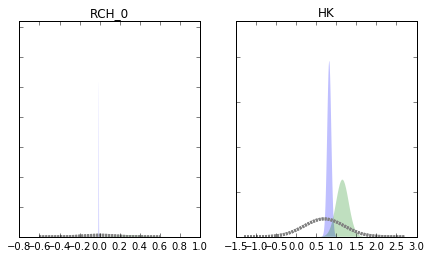

In [19]:
figs,axes = pyemu.helpers.plot_summary_distributions(df_paru,subplots=True)
for pname,ax in zip(pst.adj_par_names,axes):
    pyemu.helpers.plot_summary_distributions(df_paru_base.loc[[pname.upper()],:],ax=ax,pt_color="g")

##  Wow, from an uncertainty standpoint, the flux observation has helped us learn a lot about recharge, and the uncertainty in HK improved to (blue posterior is narrower and higher than green)

# Advanced digression - what's wrong with FOSM...
### Why are the Prior distributions for the flux obs and no flux obs forecasts different? - I thought Priors should be the same between these two?

In [20]:
jco = pyemu.Jco.from_binary(os.path.join(working_dir,pst_name.replace(".pst",".jcb")))

df = jco.to_dataframe()

df.loc["travel_time",:]

rch_0    3.700031e-10
hk      -4.088192e+04
Name: travel_time, dtype: float64

In [21]:
jco = pyemu.Jco.from_binary(os.path.join("..","freyberg_k_and_r",working_dir,pst_name.replace(".pst",".jcb")))

df2 = jco.to_dataframe()
df2.loc["travel_time",:]

rch_0        1.703796
hk      -21969.704019
Name: travel_time, dtype: float64

### well the parameter sensitivity is different at these different optimal values.... 

# Okay - enough diregression:  let's look at our forecasts - here's the K and R model with the flux observation with weight:

In [22]:
df_foreu = pd.read_csv(os.path.join(working_dir,pst_name.replace(".pst",".pred.usum.csv")),index_col=0)
df_foreu.loc[:,"reduction"] = 100.0 *  (1.0 - (df_foreu.post_stdev / df_foreu.prior_stdev))

df_foreu

,prior_mean,prior_stdev,prior_lower_bound,prior_upper_bound,post_mean,post_stdev,post_lower_bound,post_upper_bound,reduction
name,,,,,,,,,
FLX_RIVER_L_19750102,-1436.1400,204.135000,-1844.4100,-1027.8700,-1480.4500,20.771900,-1521.9900,-1438.9100,89.824430
FR03C10_19750102,22.9928,3.213550,16.5657,29.4199,22.0923,0.326996,21.4383,22.7463,89.824462
FR03C16_19750102,19.7661,0.227644,19.3108,20.2214,19.7018,0.023164,19.6555,19.7481,89.824463
FR04C09_19750102,23.6465,3.750320,16.1458,31.1471,22.6020,0.381616,21.8388,23.3653,89.824442
FR10C02_19750102,28.3652,7.099480,14.1662,42.5642,26.4345,0.722410,24.9897,27.8794,89.824466
FR14C11_19750102,18.1420,0.829950,16.4821,19.8020,17.9036,0.084452,17.7347,18.0725,89.824447
FR16C17_19750102,17.2556,0.447763,16.3601,18.1511,17.1265,0.045562,17.0354,17.2176,89.824461
FR22C11_19750102,17.0533,1.386830,14.2797,19.8270,16.6588,0.141118,16.3765,16.9410,89.824420
FR23C16_19750102,15.5231,0.330213,14.8626,16.1835,15.4281,0.033601,15.3609,15.4953,89.824447


### Compare these results with the ``k_and_r`` model *without* the flux observation (below):

In [23]:
df_foreu_base = pd.read_csv(os.path.join("..","freyberg_k_and_r",
                                         working_dir,pst_name.replace(".pst",".pred.usum.csv")),index_col=0)
df_foreu_base.loc[:,"reduction"] = 100.0 *  (1.0 - (df_foreu_base.post_stdev / df_foreu_base.prior_stdev))
df_foreu_base

,prior_mean,prior_stdev,prior_lower_bound,prior_upper_bound,post_mean,post_stdev,post_lower_bound,post_upper_bound,reduction
name,,,,,,,,,
FLX_RIVER_L_19750102,-1436.1400,428.896000,-2293.9400,-578.3510,-1679.8200,134.167000,-1948.1600,-1411.4900,68.718058
FR03C10_19750102,22.9928,1.696430,19.5999,26.3857,20.5259,0.530696,19.4645,21.5873,68.716894
FR03C16_19750102,19.7661,0.118548,19.5290,20.0032,19.5945,0.037086,19.5204,19.6687,68.716891
FR04C09_19750102,23.6465,2.041760,19.5630,27.7300,20.7481,0.638725,19.4706,22.0255,68.716940
FR10C02_19750102,28.3652,4.498520,19.3682,37.3623,22.6894,1.407270,19.8749,25.5039,68.717045
FR14C11_19750102,18.1420,0.395572,17.3509,18.9332,17.5186,0.123747,17.2711,17.7660,68.716947
FR16C17_19750102,17.2556,0.211890,16.8318,17.6794,16.9195,0.066286,16.7870,17.0521,68.716787
FR22C11_19750102,17.0533,0.685233,15.6829,18.4238,16.0047,0.214362,15.5759,16.4334,68.716918
FR23C16_19750102,15.5231,0.156352,15.2104,15.8358,15.2752,0.048912,15.1774,15.3730,68.716870


### And here the forecast uncertianties are side by side

In [24]:
df_foreu_concat = pd.concat([df_foreu,df_foreu_base],join="outer",axis=1,keys=["heads+fluxobs","heads_only"])
df_foreu_concat

heads+fluxobs                                  \
                        prior_mean   prior_stdev prior_lower_bound   
name                                                                 
FLX_RIVER_L_19750102    -1436.1400    204.135000        -1844.4100   
FR03C10_19750102           22.9928      3.213550           16.5657   
FR03C16_19750102           19.7661      0.227644           19.3108   
FR04C09_19750102           23.6465      3.750320           16.1458   
FR10C02_19750102           28.3652      7.099480           14.1662   
FR14C11_19750102           18.1420      0.829950           16.4821   
FR16C17_19750102           17.2556      0.447763           16.3601   
FR22C11_19750102           17.0533      1.386830           14.2797   
FR23C16_19750102           15.5231      0.330213           14.8626   
FR25C05_19750102           21.8432      4.880840           12.0815   
FR27C07_19750102           19.4542      3.630980           12.1922   
FR30C16_19750102           13.9818      0.346703           13.2884   
FR34C08_19750102           16.9720      2.120460           12.7311   
FR35C11_19750102           14.1680      0.389514           13.3890   
TRAVEL_TIME             27691.0000  20441.000000       -13191.0000   

                                                                 \
                     prior_upper_bound   post_mean   post_stdev   
name                                                              
FLX_RIVER_L_19750102        -1027.8700  -1480.4500    20.771900   
FR03C10_19750102               29.4199     22.0923     0.326996   
FR03C16_19750102               20.2214     19.7018     0.023164   
FR04C09_19750102               31.1471     22.6020     0.381616   
FR10C02_19750102               42.5642     26.4345     0.722410   
FR14C11_19750102               19.8020     17.9036     0.084452   
FR16C17_19750102               18.1511     17.1265     0.045562   
FR22C11_19750102               19.8270     16.6588     0.141118   
FR23C16_19750102               16.1835     15.4281     0.033601   
FR25C05_19750102               31.6049     20.5042     0.496651   
FR27C07_19750102               26.7161     18.4472     0.369471   
FR30C16_19750102               14.6753     13.8820     0.035279   
FR34C08_19750102               21.2129     16.3752     0.215768   
FR35C11_19750102               14.9470     14.0567     0.039635   
TRAVEL_TIME                 68572.9000  21841.5000  2079.980000   

                                                                   heads_only  \
                     post_lower_bound post_upper_bound  reduction  prior_mean   
name                                                                            
FLX_RIVER_L_19750102       -1521.9900       -1438.9100  89.824430  -1436.1400   
FR03C10_19750102              21.4383          22.7463  89.824462     22.9928   
FR03C16_19750102              19.6555          19.7481  89.824463     19.7661   
FR04C09_19750102              21.8388          23.3653  89.824442     23.6465   
FR10C02_19750102              24.9897          27.8794  89.824466     28.3652   
FR14C11_19750102              17.7347          18.0725  89.824447     18.1420   
FR16C17_19750102              17.0354          17.2176  89.824461     17.2556   
FR22C11_19750102              16.3765          16.9410  89.824420     17.0533   
FR23C16_19750102              15.3609          15.4953  89.824447     15.5231   
FR25C05_19750102              19.5109          21.4975  89.824477     21.8432   
FR27C07_19750102              17.7082          19.1861  89.824483     19.4542   
FR30C16_19750102              13.8115          13.9526  89.824461     13.9818   
FR34C08_19750102              15.9437          16.8068  89.824472     16.9720   
FR35C11_19750102              13.9774          14.1359  89.824448     14.1680   
TRAVEL_TIME                17681.5000       26001.4000  89.824470  27691.0000   

                                                                        \
                    

### and plotted ( (blue is with flux observation weighted, green is with zero weight on the flux target)

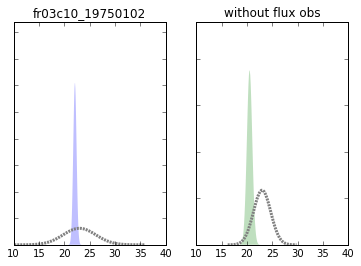

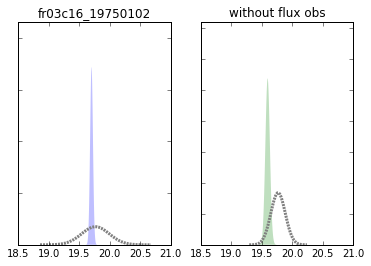

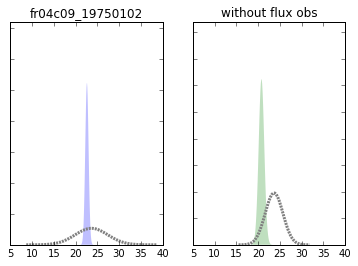

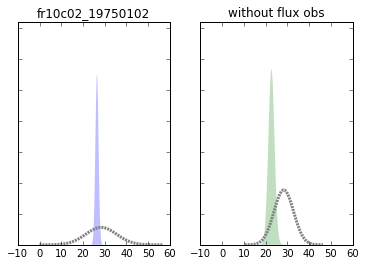

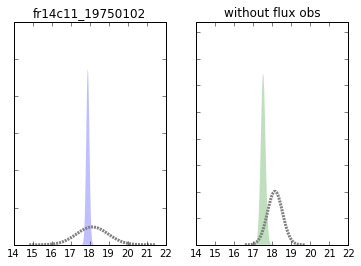

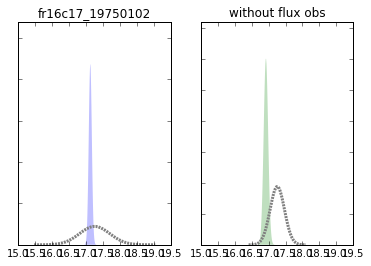

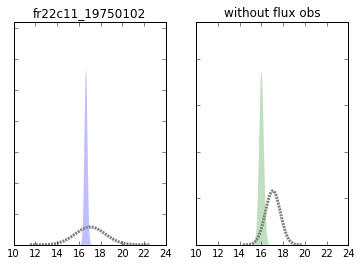

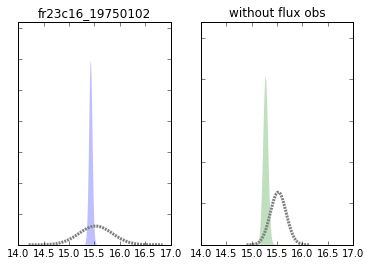

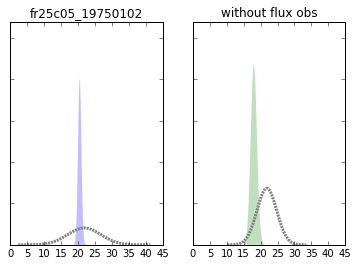

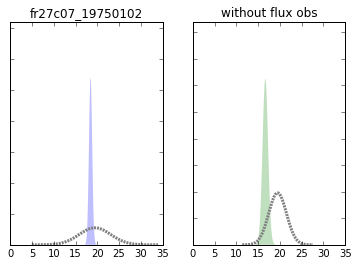

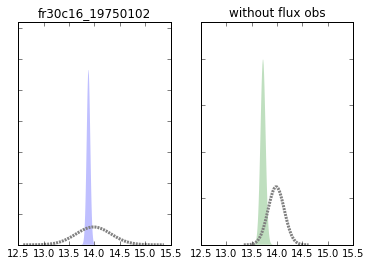

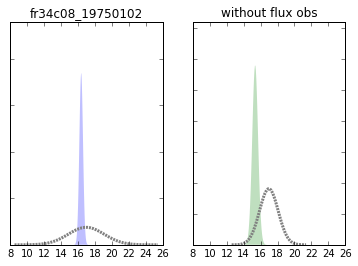

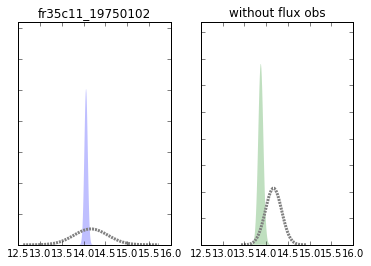

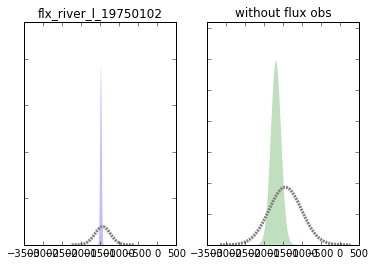

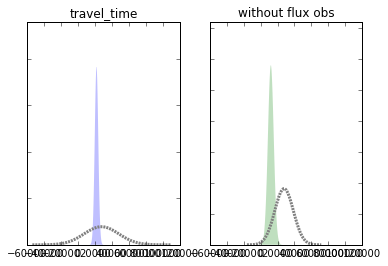

In [25]:
for forecast in pst.forecast_names:
    ax1 = plt.subplot(121)
    ax2 = plt.subplot(122)
    pyemu.helpers.plot_summary_distributions(df_foreu.loc[[forecast.upper()],:],ax=ax1)
    pyemu.helpers.plot_summary_distributions(df_foreu_base.loc[[forecast.upper()],:],
                                             ax=ax2,pt_color='g')
    xlim1, xlim2 = ax1.get_xlim(),ax2.get_xlim()
    xmx = max(xlim1[1],xlim2[1])
    xmn = min(xlim1[0],xlim2[0])
    ax1.set_xlim(xmn,xmx)
    ax2.set_xlim(xmn,xmx)
    ax1.set_title(forecast)
    ax2.set_title("without flux obs")
    plt.show()

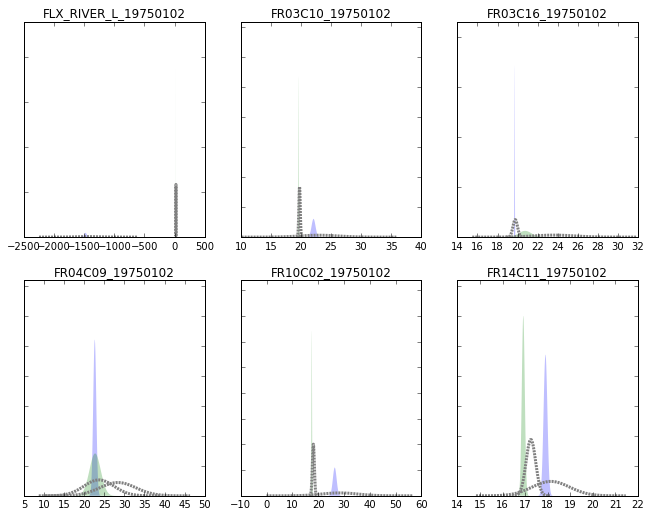

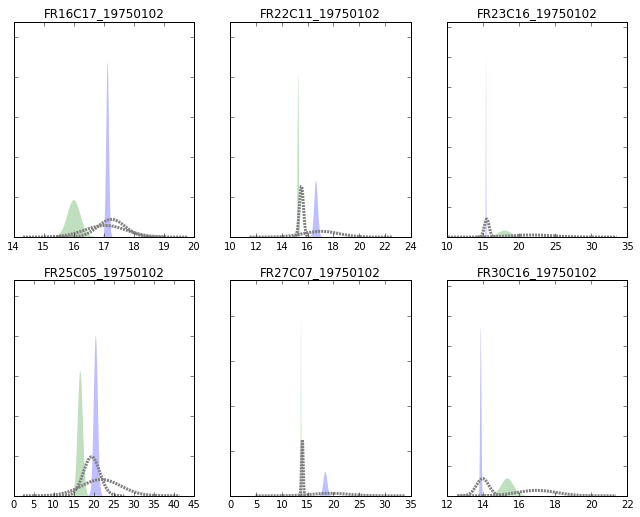

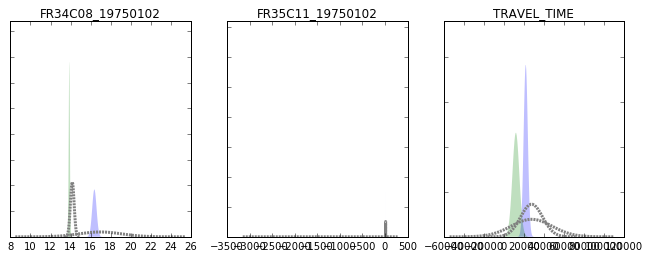

In [26]:
figs, axes = pyemu.helpers.plot_summary_distributions(df_foreu,subplots=True)
for fname,ax in zip(pst.forecast_names,axes):
    pyemu.helpers.plot_summary_distributions(df_foreu_base.loc[[fname.upper()],:],ax=ax,pt_color="g")
    

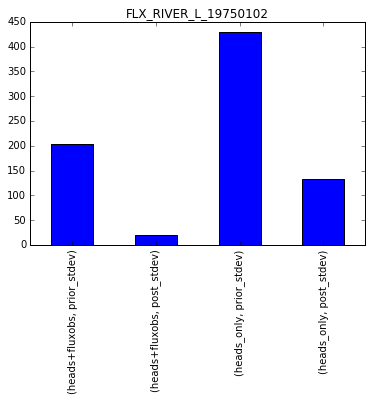

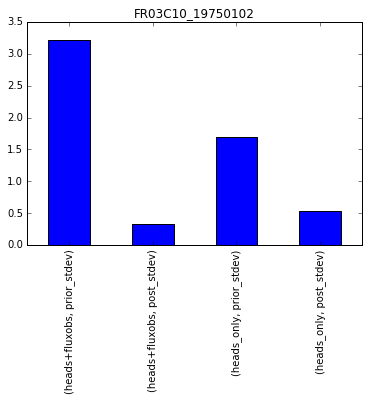

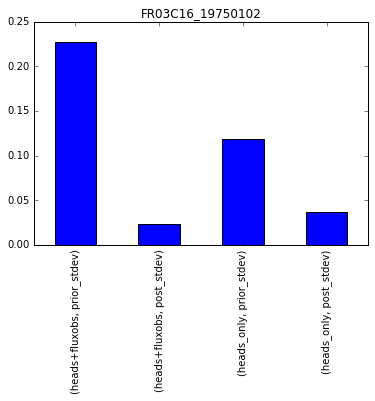

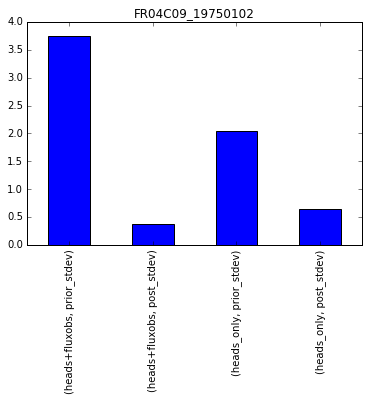

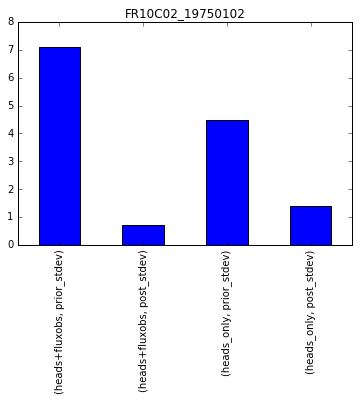

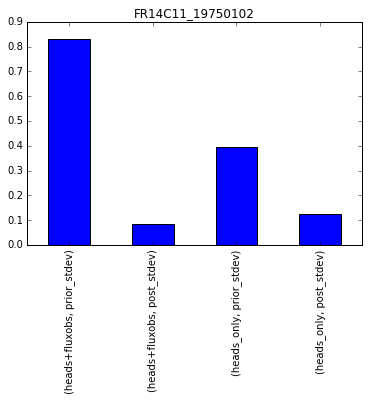

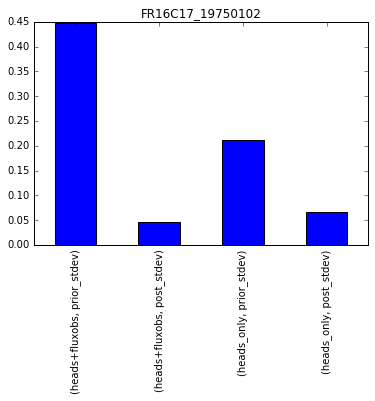

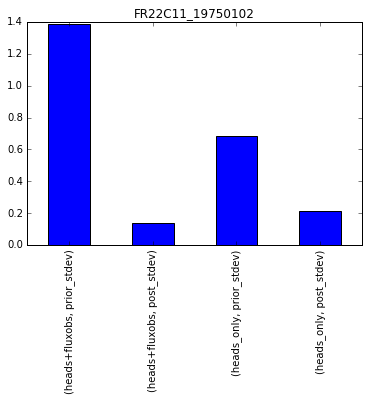

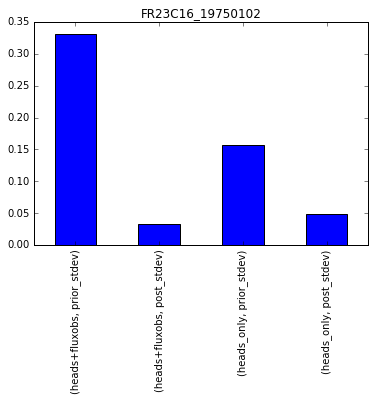

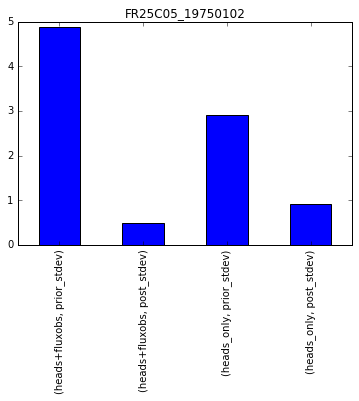

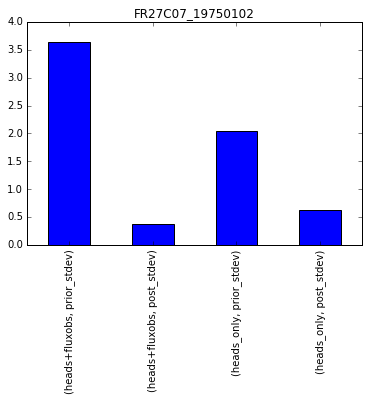

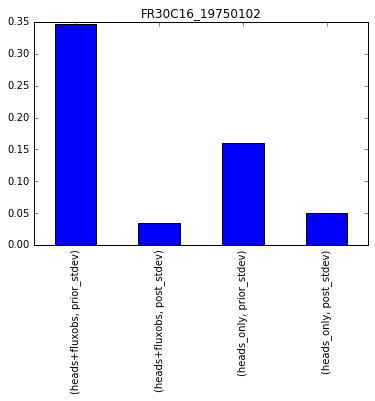

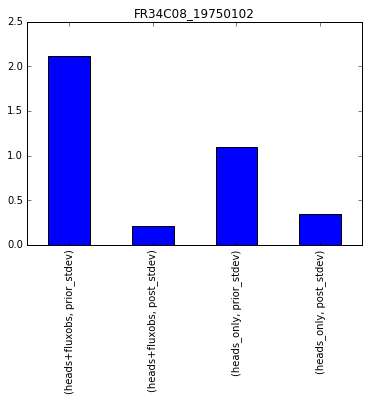

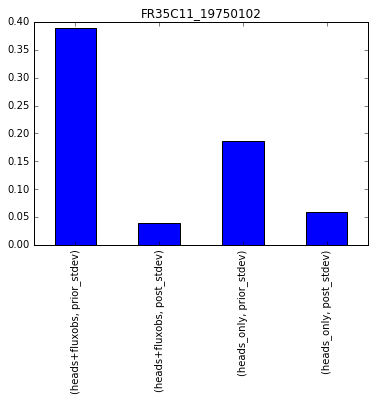

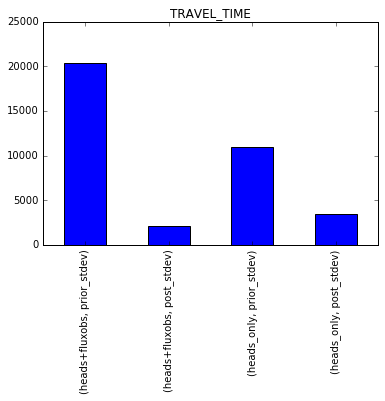

In [27]:
for forecast in df_foreu_concat.index:
    df_foreu_concat.loc[forecast,(slice(None),("prior_stdev","post_stdev"))].plot(kind="bar",subplots=True)
    plt.show()

### The information in the flux obs has reduced river flux forecast uncertainty dramatically, but has not really improved what we had before with respect to the ``travel_time`` or head forecasts.  So on first blush we see that the same model/observation data set can make some forecasts better but not others

### But there is more to it than that - think about which observation helped which parameter and which forecast the most.  Is there an "birds of the feather" type of thing going on?  


# Okay, we took you a long way but doesn't our approach to uncertainty have a huge flaw?  We freed recharge rch_0 which is the calibration period that we know something about.  But we left the recharge in the forecast period (rch_1) fixed - which is saying that we know it perfectly, which makes no sense.  This set of blocks will recreate the steps above and get us back to the parameter and forecast uncertainty plots....

In [28]:
pst.parameter_data.loc[["rch_0","rch_1"],"partrans"] = "log"


pst.write(os.path.join(working_dir,pst_name))
pst.parameter_data

pyemu.helpers.run("pestchek {0}".format(pst_name),cwd=working_dir)

run():./pestchek freyberg_kr.pst


In [29]:
pyemu.helpers.run("pestpp {0}".format(pst_name),cwd=working_dir)

run():./pestpp freyberg_kr.pst


In [30]:
df_obj = pd.read_csv(os.path.join(working_dir,pst_name.replace(".pst",".iobj")),index_col=0)
df_obj

,model_runs_completed,total_phi,measurement_phi,regularization_phi,flx_river_l,forehead,vol_total,flx_recharg,vol_storage,vol_percent,...,vol_recharg,flx_storage,head,flx_in-out,vol_river_l,vol_constan,flx_total,flx_percent,pothead,foreflux
iteration,,,,,,,,,,,,,,,,,,,,,
0,0,1336.490,1336.490,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,10,830.708,830.708,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,19,826.072,826.072,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,31,826.066,826.066,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [31]:
df_paru = pd.read_csv(os.path.join(working_dir,pst_name.replace(".pst",".par.usum.csv")),index_col=0)
df_paru

,prior_mean,prior_stdev,prior_lower_bound,prior_upper_bound,post_mean,post_stdev,post_lower_bound,post_upper_bound
name,,,,,,,,
RCH_0,0.00000,0.150515,-0.30103,0.30103,-0.008678,0.001540,-0.011757,-0.005598
RCH_1,0.00000,0.150515,-0.30103,0.30103,0.000000,0.150515,-0.301030,0.301030
HK,0.69897,0.500000,-0.30103,1.69897,0.823856,0.050878,0.722101,0.925612


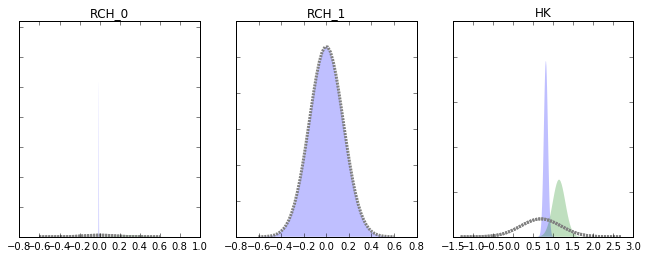

In [32]:
figs,axes = pyemu.helpers.plot_summary_distributions(df_paru,subplots=True)
for pname,ax in zip(pst.adj_par_names,axes):
    if pname.upper() == "RCH_1":
        continue
    pyemu.helpers.plot_summary_distributions(df_paru_base.loc[[pname.upper()],:],ax=ax,pt_color="g")

# Ah, for the future recharge there is not change between the prior and posterior uncertainty, but this makes sense because there are no weighted observations (information) regarding the future. So our calibration data tells us nothing about the this parameter.  

## How does this new source of uncertainty ripple to our forecast uncertainty?

# Jeremy - can you fix this so it plots the rch_1 fixed vs freed change in FOSM?

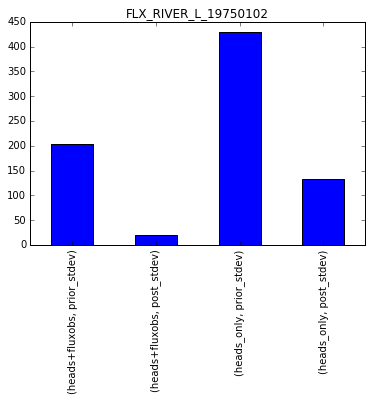

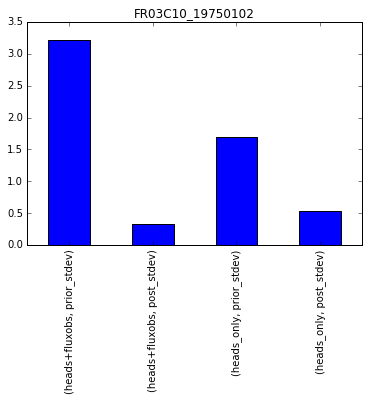

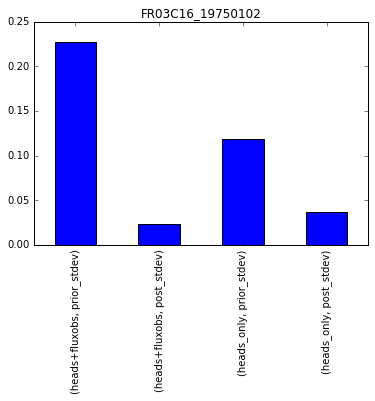

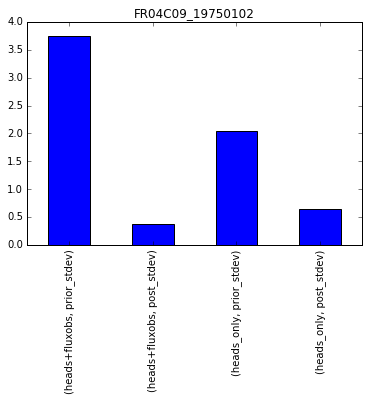

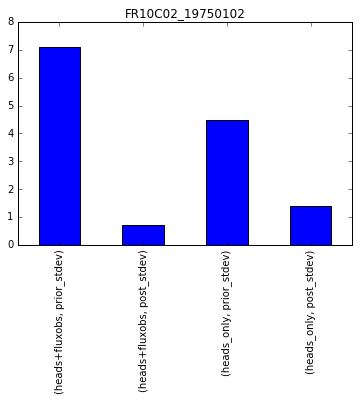

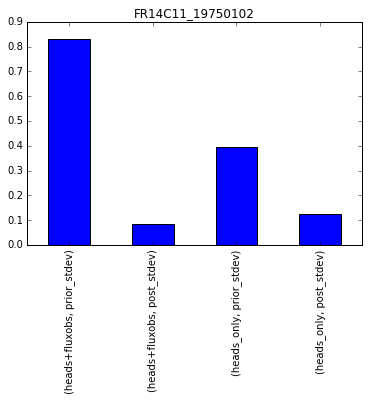

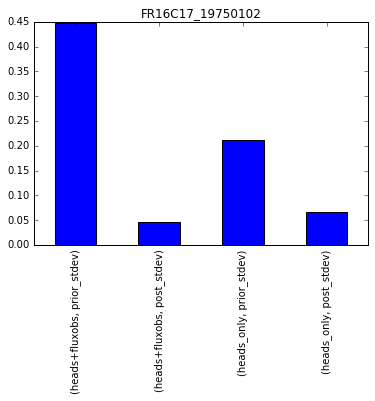

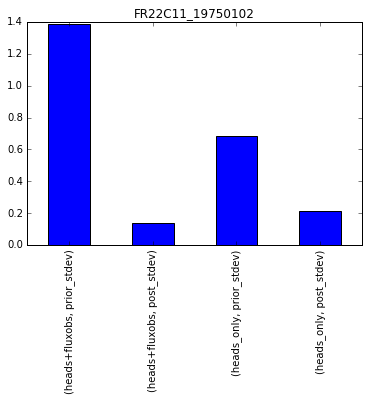

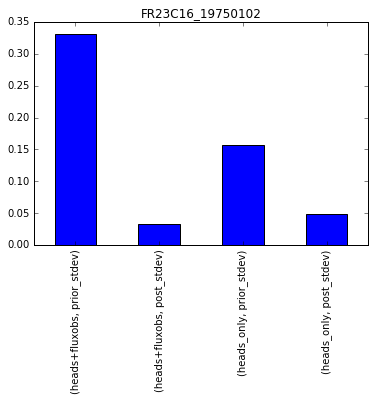

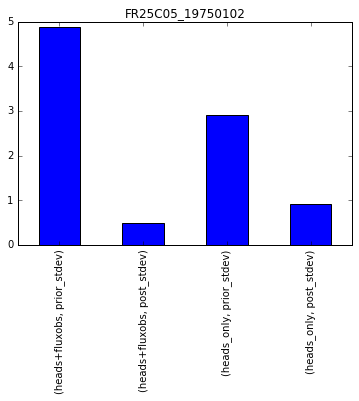

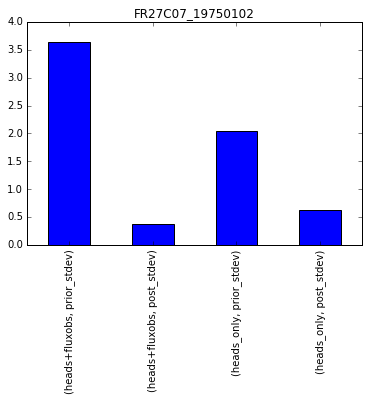

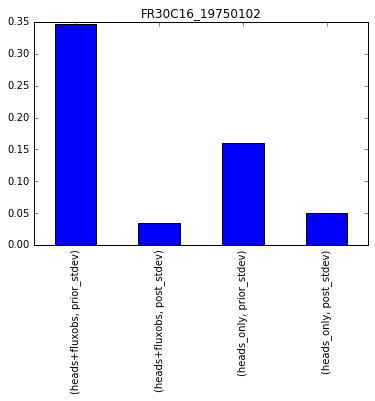

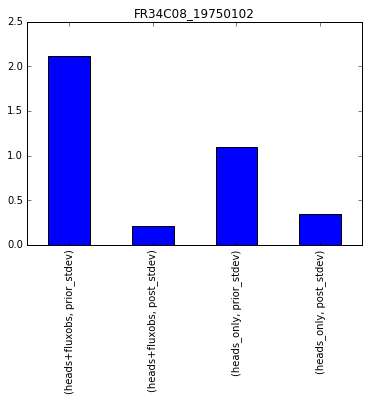

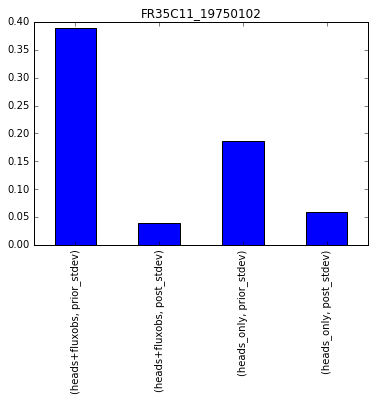

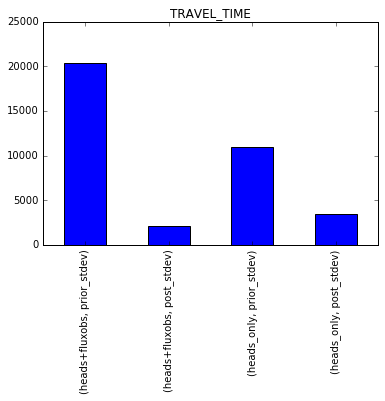

In [33]:
for forecast in df_foreu_concat.index:
    df_foreu_concat.loc[forecast,(slice(None),("prior_stdev","post_stdev"))].plot(kind="bar",subplots=True)
    plt.show()